# Ensemble Inference for Marathi Sentiment Analysis

This notebook performs sentiment analysis on Marathi text by creating a weighted ensemble of multiple transformer models from the Hugging Face Hub.

### Key Features:
- **Model Loading**: Dynamically loads specified models and tokenizers.
- **Ensemble Strategy**: Uses weighted soft-voting on the models' probability outputs.
- **Evaluation**: Computes accuracy, macro F1-score, and generates a detailed classification report.
- **Visualization**: Displays a confusion matrix to visualize model performance.
- **Reproducibility**: Saves metrics and predictions to disk for further analysis.

Let's start by installing the necessary dependencies.

In [14]:
!pip install -q transformers pandas torch scikit-learn seaborn matplotlib wordcloud

### Check PyTorch and CUDA Setup
The following cell checks if a GPU is available and prints information about the PyTorch and CUDA setup. If `torch.cuda.is_available()` returns `False`, it means PyTorch cannot find a compatible GPU, and the notebook will fall back to using the CPU.

In [15]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 1. Imports and Setup

Import all the required libraries and define constants. The `CANONICAL_LABELS` are the standard sentiment classes we'll use across all models.

In [16]:
import json
from pathlib import Path
from typing import List, Tuple, Dict

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from wordcloud import WordCloud

# Define the canonical labels in a specific order for consistency
CANONICAL_LABELS = ["negative", "neutral", "positive"]
CANONICAL_TO_ID = {lbl: i for i, lbl in enumerate(CANONICAL_LABELS)}

## 2. Model Configuration and Loading

Here, we define the models we want to ensemble. The `resolve_label_mapping` function is a helper to align the labels from different models to our canonical `["negative", "neutral", "positive"]` order. The `load_models` function will then download and prepare the models and tokenizers for inference.

We will use the top-performing models identified in the project's README:
- `AshParmar/XMR-Muril`
- `AshParmar/XMR-Albert`
- `AshParmar/XMR-MBERT`

Their weights are derived from their respective macro F1-scores.

In [9]:
def resolve_label_mapping(model_id: str, num_labels: int, id2label: Dict[int, str]) -> List[int]:
    """
    Build an index mapping from model's label order to canonical order.

    Returns a list idx_map where probs_model[:, j] should be added to
    probs_ensemble[:, idx_map[j]]. If an exact name match isn't found,
    best-effort fallbacks are used for typical 3-class sentiment.
    """
    if id2label:
        # Normalize names (lowercase, strip)
        norm = {i: id2label[i].lower().strip() for i in id2label}
        # Try direct name-based mapping
        name_to_idx = {v: k for k, v in norm.items()}
        if all(lbl in name_to_idx for lbl in CANONICAL_LABELS):
            return [name_to_idx[lbl] for lbl in CANONICAL_LABELS]

        # Common alternative spellings or tags
        aliases = {
            "neg": "negative",
            "pos": "positive",
            "neu": "neutral",
        }
        rev = {}
        for i, name in norm.items():
            key = aliases.get(name, name)
            rev[key] = i
        if all(lbl in rev for lbl in CANONICAL_LABELS):
            return [rev[lbl] for lbl in CANONICAL_LABELS]

    # Fallback: assume label indices 0,1,2 map to negative, neutral, positive
    if num_labels == 3:
        return [0, 1, 2]

    raise ValueError(
        f"Model {model_id} has {num_labels} labels and no recognizable id2label mapping; cannot ensemble."
    )


def load_models(model_repos: List[str], device: torch.device) -> Tuple[List[AutoTokenizer], List[AutoModelForSequenceClassification], List[List[int]]]:
    tokenizers = []
    models = []
    reorder_indices = []
    for repo in model_repos:
        try:
            tok = AutoTokenizer.from_pretrained(repo)
            mdl = AutoModelForSequenceClassification.from_pretrained(repo)
            mdl.to(device)
            mdl.eval()
            num_labels = mdl.config.num_labels
            id2label = None
            # id2label may be list or dict
            if hasattr(mdl.config, "id2label") and mdl.config.id2label:
                if isinstance(mdl.config.id2label, dict):
                    id2label = {int(k): v for k, v in mdl.config.id2label.items()}
                elif isinstance(mdl.config.id2label, list):
                    id2label = {i: v for i, v in enumerate(mdl.config.id2label)}
            idx_map = resolve_label_mapping(repo, num_labels, id2label or {})

            tokenizers.append(tok)
            models.append(mdl)
            reorder_indices.append(idx_map)
            print(f"Loaded {repo} (num_labels={num_labels})")
        except Exception as e:
            print(f"Warning: failed to load {repo}: {e}")

    if not models:
        raise RuntimeError("No models could be loaded. Check repo IDs and internet connectivity.")

    return tokenizers, models, reorder_indices

def default_top_models() -> Tuple[List[str], List[float]]:
    # Defaults based on README results (macro F1)
    repos = [
        "AshParmar/XMR-Muril",
        "AshParmar/XMR-Albert",
        "AshParmar/XMR-MBERT",
    ]
    weights = [0.79255, 0.779034, 0.776411]
    return repos, weights

## 3. Ensemble Inference Logic

The `run_ensemble` function orchestrates the entire process:
1.  **Loads Data**: Reads the test CSV file.
2.  **Loads Models**: Calls `load_models` to get the models and tokenizers.
3.  **Inference Loop**: Iterates through the text data in batches.
    - For each model, it generates predictions (logits).
    - It converts logits to probabilities using a `softmax` function.
    - It reorders the probabilities to match the canonical label order.
    - It applies the model-specific weight and accumulates the results.
4.  **Final Prediction**: The label with the highest weighted-average probability is chosen as the final prediction.
5.  **Metrics Calculation**: It computes accuracy, F1-score, and a classification report.

In [10]:
def batch_iter(texts: List[str], batch_size: int):
    for i in range(0, len(texts), batch_size):
        yield texts[i : i + batch_size]


def softmax(logits: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.softmax(logits, dim=-1)


def run_ensemble(
    model_repos: List[str],
    weights: List[float],
    test_csv: Path,
    text_col: str = "text",
    label_col: str = "label",
    batch_size: int = 32,
    max_length: int = 192,
    device: torch.device = torch.device("cpu"),
) -> Dict:
    assert len(model_repos) == len(weights), "Number of weights must match number of models"
    # Normalize weights
    w = torch.tensor(weights, dtype=torch.float32)
    w = w / w.sum()

    df = pd.read_csv(test_csv)
    if text_col not in df.columns:
        raise ValueError(f"Column '{text_col}' not found in {test_csv}")

    # Build y_true using preferred label column
    if label_col in df.columns:
        # Map string labels to canonical ids
        def label_to_id(x: str) -> int:
            key = str(x).strip().lower()
            if key not in CANONICAL_TO_ID:
                raise ValueError(f"Unknown label '{x}' in column '{label_col}'. Expected one of {CANONICAL_LABELS}")
            return CANONICAL_TO_ID[key]

        y_true = df[label_col].map(label_to_id).tolist()
    elif "label_raw" in df.columns:
        raw_to_canonical = {-1: 0, 0: 1, 1: 2}
        y_true = df["label_raw"].map(raw_to_canonical).tolist()
    else:
        raise ValueError("No suitable label column found. Expected 'label' or 'label_raw'.")

    texts = df[text_col].astype(str).tolist()

    tokenizers, models, reorder = load_models(model_repos, device)

    # Inference loop
    all_probs = []
    with torch.no_grad():
        for chunk in batch_iter(texts, batch_size):
            # For each model, compute probs and reorder to canonical
            probs_accum = None
            for m_idx, (tok, mdl, idx_map) in enumerate(zip(tokenizers, models, reorder)):
                enc = tok(
                    chunk,
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors="pt",
                )
                enc = {k: v.to(device) for k, v in enc.items()}
                logits = mdl(**enc).logits  # [B, C_model]
                probs = softmax(logits)
                # Reorder columns from model order -> canonical order
                probs = probs[:, idx_map]
                # Weighted sum
                weighted = probs * w[m_idx]
                probs_accum = weighted if probs_accum is None else probs_accum + weighted

            all_probs.append(probs_accum.cpu())

    probs_cat = torch.cat(all_probs, dim=0)  # [N, 3]
    y_pred = probs_cat.argmax(dim=1).tolist()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    report = classification_report(y_true, y_pred, target_names=CANONICAL_LABELS, output_dict=True)
    cm = confusion_matrix(y_true, y_pred).tolist()

    return {
        "accuracy": acc,
        "macro_f1": f1,
        "classification_report": report,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred,
    }

## 4. Execution and Evaluation

Now, we'll run the ensemble and evaluate its performance.

- **Device Selection**: It will automatically use a CUDA-enabled GPU if available, otherwise it will fall back to the CPU.
- **Data Path**: The test data is loaded from the `output/combined_dataset` directory.
- **Results**: The final metrics are printed, and the results dictionary is saved for inspection.

In [12]:
# --- Configuration ---
TEST_CSV = Path("C:\\IndiLlama\\IndiLlama\\output\\test_strict_domain.csv")
TEXT_COL = "text"
LABEL_COL = "label"
BATCH_SIZE = 8
MAX_LENGTH = 192
OUT_DIR = Path("..") / "output"

# --- Execution ---
models, weights = default_top_models()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Models: {models}")
print(f"Weights: {weights}")

# Create output directory if it doesn't exist
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Run the ensemble
results = run_ensemble(
    model_repos=models,
    weights=weights,
    test_csv=TEST_CSV,
    text_col=TEXT_COL,
    label_col=LABEL_COL,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH,
    device=device,
)

# --- Display Results ---
print("\nEnsemble Metrics:")
print(f"  Accuracy: {results['accuracy']:.4f}")
print(f"  Macro F1: {results['macro_f1']:.4f}")

# Save results for reproducibility
results_path = OUT_DIR / "ensemble_results.json"
preds_path = OUT_DIR / "ensemble_predictions.csv"

payload = {
    "metrics": {k: v for k, v in results.items() if k not in ("y_true", "y_pred")},
    "metadata": {
        "models": models,
        "weights": weights,
        "device": str(device),
        "test_csv": str(TEST_CSV.resolve()),
        "text_col": TEXT_COL,
        "label_col": LABEL_COL,
        "batch_size": BATCH_SIZE,
        "max_length": MAX_LENGTH,
    },
}
with open(results_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

# Attach predictions to the input CSV rows
df = pd.read_csv(TEST_CSV)
df_out = df.copy()
inv_map = {i: lbl for lbl, i in CANONICAL_TO_ID.items()}
df_out["pred_label"] = [inv_map[i] for i in results["y_pred"]]
df_out.to_csv(preds_path, index=False)

print(f"\nSaved metrics to: {results_path}")
print(f"Saved predictions to: {preds_path}")

Using device: cuda
Models: ['AshParmar/XMR-Muril', 'AshParmar/XMR-Albert', 'AshParmar/XMR-MBERT']
Weights: [0.79255, 0.779034, 0.776411]
Loaded AshParmar/XMR-Muril (num_labels=3)
Loaded AshParmar/XMR-Muril (num_labels=3)
Loaded AshParmar/XMR-Albert (num_labels=3)
Loaded AshParmar/XMR-Albert (num_labels=3)
Loaded AshParmar/XMR-MBERT (num_labels=3)
Loaded AshParmar/XMR-MBERT (num_labels=3)

Ensemble Metrics:
  Accuracy: 0.9080
  Macro F1: 0.9076

Saved metrics to: ..\output\ensemble_results.json
Saved predictions to: ..\output\ensemble_predictions.csv

Ensemble Metrics:
  Accuracy: 0.9080
  Macro F1: 0.9076

Saved metrics to: ..\output\ensemble_results.json
Saved predictions to: ..\output\ensemble_predictions.csv


## 5. Visualization: Confusion Matrix

A confusion matrix helps us understand the performance of the classification model by showing the counts of true vs. predicted labels for each class. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled.

## 6. Visualization: Word Cloud (Devanagari)

The following cell generates a word cloud from the text column using a Devanagari font for proper rendering of Marathi script.

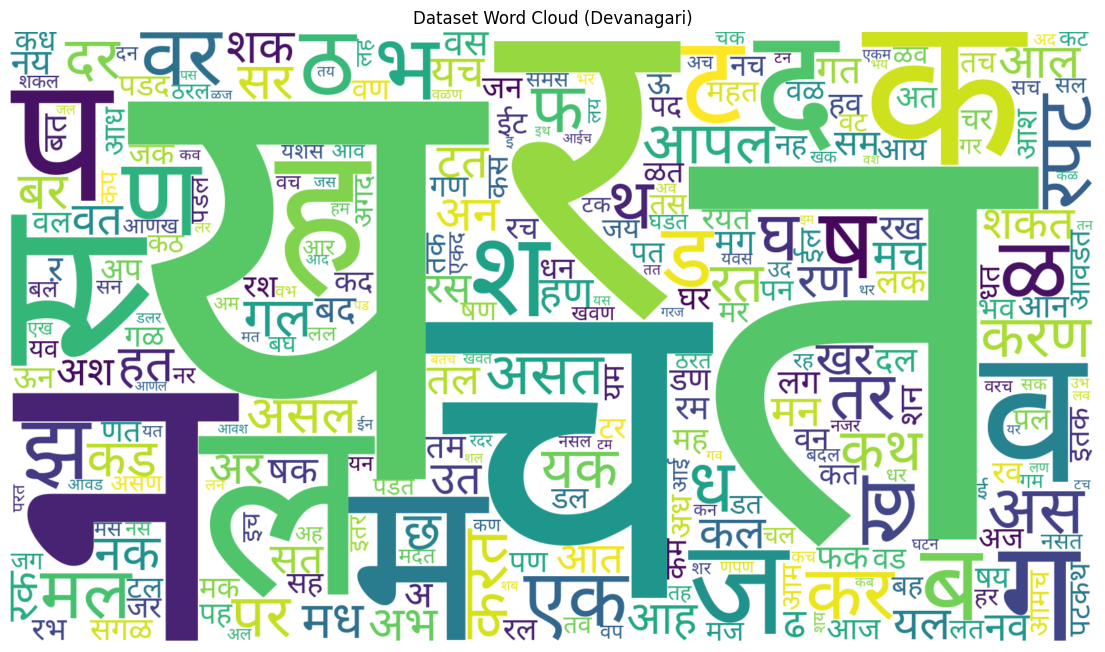

Saved dataset word cloud to: ..\output\wordcloud_dataset.png


In [24]:
# Devanagari Word Cloud for entire dataset
import re
from collections import Counter
from pathlib import Path
from wordcloud import WordCloud, STOPWORDS

# Prepare stopwords: base + Marathi additions
marathi_stopwords = set([
    "आहे", "होते", "होता", "होती", "होत", "आहेत", "आणि", "किंवा", "पण", "मात्र", "जर",
    "तर", "म्हणून", "म्हणजे", "काय", "कोण", "कशी", "कसे", "का", "येते", "येणार",
    "आपण", "आम्ही", "तू", "तो", "ती", "ते", "हे", "ही", "हया", "त्याने", "त्याची",
    "त्यांचे", "त्यांना", "त्यात", "त्यावर", "त्यातून", "येथे", "तिथे", "इथे", "कुठे",
    "असं", "तसं", "काही", "सर्व", "खूप", "थोडे", "जास्त", "नाही", "हो", "नको", "होय"
])
all_stopwords = set(STOPWORDS) | {s.lower() for s in marathi_stopwords}

# Tokenization: keep Devanagari words (>=2 chars)
token_regex = r"[\u0900-\u097F]{2,}"

def extract_tokens(text: str):
    if not isinstance(text, str):
        text = str(text)
    toks = re.findall(token_regex, text)
    return [t for t in toks if t.lower() not in all_stopwords]

# Build corpus
try:
    df_wc = pd.read_csv(TEST_CSV)
except Exception:
    df_wc = df.copy() if 'df' in globals() else pd.DataFrame()

texts = df_wc.get(TEXT_COL, pd.Series(dtype=str)).astype(str).tolist()
all_tokens = []
for t in texts:
    all_tokens.extend(extract_tokens(t))

corpus = " ".join(all_tokens)

# Font path for Devanagari
font_path = (Path("..") / "fonts" / "NotoSansDevanagari-Regular.ttf")
if not font_path.exists():
    font_path = None

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    font_path=str(font_path) if font_path else None,
    collocations=False,
    prefer_horizontal=0.9,
    max_words=300,
).generate(corpus)

wc_path = OUT_DIR / "wordcloud_dataset.png"
wc.to_file(wc_path)
plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Dataset Word Cloud (Devanagari)")
plt.show()
print(f"Saved dataset word cloud to: {wc_path}")

## 7. Visualization: Word Clouds by Predicted Sentiment

The following cell creates separate word clouds for the predicted classes: positive, neutral, and negative. It uses the predictions generated above (or loads them from `ensemble_predictions.csv` if needed).

In [ ]:
# Word Clouds by Predicted Sentiment (positive, neutral, negative)
import re
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

# Load predictions
preds_csv = OUT_DIR / "ensemble_predictions.csv"
if 'df_out' in globals() and isinstance(df_out, pd.DataFrame) and 'pred_label' in df_out.columns:
    df_preds = df_out.copy()
else:
    df_preds = pd.read_csv(preds_csv)

# Prepare stopwords and tokenizer
marathi_stopwords = set([
    "आहे", "होते", "होता", "होती", "होत", "आहेत", "आणि", "किंवा", "पण", "मात्र", "जर",
    "तर", "म्हणून", "म्हणजे", "काय", "कोण", "कशी", "कसे", "का", "येते", "येणार",
    "आपण", "आम्ही", "तू", "तो", "ती", "ते", "हे", "ही", "हया", "त्याने", "त्याची",
    "त्यांचे", "त्यांना", "त्यात", "त्यावर", "त्यातून", "येथे", "तिथे", "इथे", "कुठे",
    "असं", "तसं", "काही", "सर्व", "खूप", "थोडे", "जास्त", "नाही", "हो", "नको", "होय"
])
all_stopwords = set(STOPWORDS) | {s.lower() for s in marathi_stopwords}

token_regex = r"[\u0900-\u097F]{2,}"

def extract_tokens(text: str):
    toks = re.findall(token_regex, str(text))
    return [t for t in toks if t.lower() not in all_stopwords]

by_label = defaultdict(list)
for _, row in df_preds.iterrows():
    label = str(row.get('pred_label', '')).strip().lower()
    text = row.get(TEXT_COL, '')
    for tok in extract_tokens(text):
        by_label[label].append(tok)

label_order = ["positive", "neutral", "negative"]
colors = {
    "positive": "Greens",
    "neutral": "Blues",
    "negative": "Reds",
}
font_path = (Path("..") / "fonts" / "NotoSansDevanagari-Regular.ttf")
if not font_path.exists():
    font_path = None

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, lbl in enumerate(label_order):
    tokens = by_label.get(lbl, [])
    corpus = " ".join(tokens)
    if not corpus:
        axes[idx].axis('off')
        axes[idx].set_title(f"{lbl.title()} (no data)")
        continue
    wc = WordCloud(
        width=900, height=600, background_color="white", font_path=str(font_path) if font_path else None,
        collocations=False, prefer_horizontal=0.9, max_words=250, colormap=colors[lbl]
    ).generate(corpus)
    axes[idx].imshow(wc, interpolation="bilinear")
    axes[idx].axis("off")
    axes[idx].set_title(f"Predicted: {lbl.title()}")

plt.tight_layout()
plt.show()

# Save individual clouds too
for lbl in label_order:
    tokens = by_label.get(lbl, [])
    corpus = " ".join(tokens)
    if not corpus:
        continue
    wc_img = WordCloud(
        width=1600, height=900, background_color="white", font_path=str(font_path) if font_path else None,
        collocations=False, prefer_horizontal=0.9, max_words=300, colormap=colors[lbl]
    ).generate(corpus)
    out_path = OUT_DIR / f"wordcloud_{lbl}.png"
    wc_img.to_file(out_path)
    print(f"Saved {lbl} word cloud to: {out_path}")

## 8. Visualization: Balanced, Color-Coded Sentiment Word Cloud

This section builds a single word cloud using an equal number of tokens from each predicted class (positive/neutral/negative). Words are colored by sentiment: green for positive, blue for neutral, and red for negative. The Devanagari font is used when available.

Using predicted labels (ensemble results) for wordcloud.
Saved ..\output\wordclouds\balanced_sentiment_wordcloud_after.png


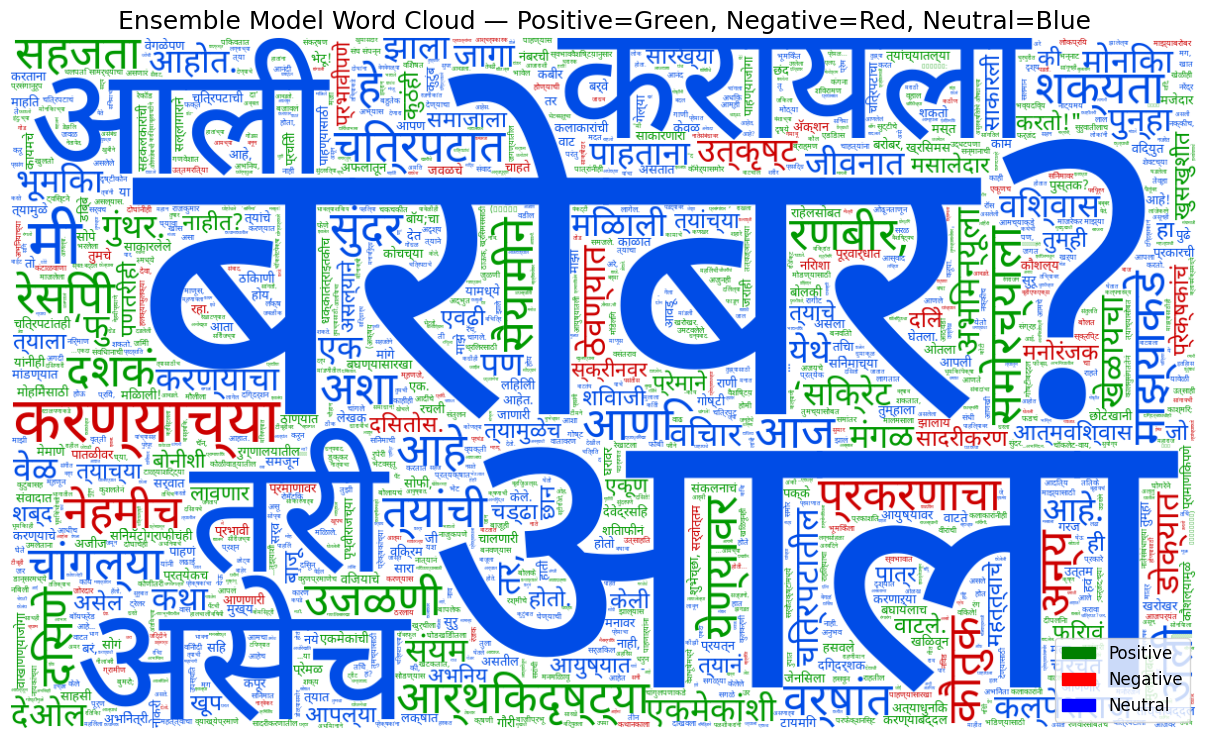

In [26]:
# Balanced, color-coded sentiment WordCloud after fine-tuning (predictions preferred)
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
try:
    import requests
except Exception:
    requests = None

# 1) Ensure a Devanagari-capable font is available (prefer local fonts folder, else try one-time download)
local_font = Path.cwd().parent / 'fonts' / 'NotoSansDevanagari-Regular.ttf'
font_path = None
if local_font.exists():
    font_path = local_font
else:
    here_font = Path('NotoSansDevanagari-Regular.ttf')
    font_path = here_font if here_font.exists() else None
    if font_path is None and requests is not None:
        try:
            url = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf'
            print(f'Downloading font from {url}...')
            r = requests.get(url)
            r.raise_for_status()
            here_font.write_bytes(r.content)
            font_path = here_font
            print('Font downloaded successfully.')
        except Exception as e:
            print('Font download failed; falling back to default font:', e)
            font_path = None

# 2) Build review texts using predictions if available (after), else ground truth
# Requires: after (with y_pred/y_true), df_test/df, ID2LABEL, RUN_DIR already defined by earlier cells
ID2LABEL = {0: "negative", 1: "neutral", 2: "positive"}
RUN_DIR = OUT_DIR

def collect_by_label_texts(df_like, label_series_str):
    text_col = 'cleaned_text' if 'cleaned_text' in df_like.columns else TEXT_COL
    pos = ' '.join(df_like[label_series_str == 'positive'][text_col].astype(str).tolist())
    neg = ' '.join(df_like[label_series_str == 'negative'][text_col].astype(str).tolist())
    neu = ' '.join(df_like[label_series_str == 'neutral'][text_col].astype(str).tolist())
    return pos, neg, neu

positive_reviews = negative_reviews = neutral_reviews = None
try:
    import pandas as pd
    if ('after' in globals()) and isinstance(after, dict) and 'y_pred' in after and 'y_true' in after:
        if 'df_test' in globals() and len(after['y_pred']) == len(df_test):
            pred_labels = pd.Series([ID2LABEL[int(i)] for i in after['y_pred']])
            positive_reviews, negative_reviews, neutral_reviews = collect_by_label_texts(df_test, pred_labels)
            print('Using predicted labels (after) for wordcloud.')
    elif ('results' in globals()) and isinstance(results, dict) and 'y_pred' in results:
        # Use ensemble results as fallback for 'after'
        if 'df' in globals() and len(results['y_pred']) == len(df):
            pred_labels = pd.Series([ID2LABEL[int(i)] for i in results['y_pred']])
            positive_reviews, negative_reviews, neutral_reviews = collect_by_label_texts(df, pred_labels)
            print('Using predicted labels (ensemble results) for wordcloud.')
except Exception as e:
    print('Prediction-based wordcloud fallback:', e)

if not positive_reviews or not negative_reviews or not neutral_reviews:
    import pandas as pd
    src_df = df_test if 'df_test' in globals() else (df if 'df' in globals() else None)
    if src_df is not None and 'label_id' in src_df.columns:
        gt_labels = pd.Series([ID2LABEL[int(i)] for i in src_df['label_id'].astype(int)])
        positive_reviews, negative_reviews, neutral_reviews = collect_by_label_texts(src_df, gt_labels)
        print('Using ground-truth labels for wordcloud.')
    else:
        print('No suitable dataframe found for wordcloud.')
        positive_reviews = negative_reviews = neutral_reviews = ''

# 3) Tokenize and balance class representation by sampling equal numbers of tokens
pos_words = [w.strip() for w in positive_reviews.split() if w.strip()]
neg_words = [w.strip() for w in negative_reviews.split() if w.strip()]
neu_words = [w.strip() for w in neutral_reviews.split() if w.strip()]

min_len = min(len(pos_words), len(neg_words), len(neu_words))
if min_len == 0:
    print('Skipping wordcloud: one or more sentiments have zero tokens.')
else:
    random.seed(42)
    pos_sample = random.sample(pos_words, min_len)
    neg_sample = random.sample(neg_words, min_len)
    neu_sample = random.sample(neu_words, min_len)

    # Equalize frequencies (all sampled words get freq=1)
    word_frequencies, word_sentiment = {}, {}
    for w in pos_sample:
        word_frequencies[w] = 1; word_sentiment[w] = 'positive'
    for w in neg_sample:
        word_frequencies[w] = 1; word_sentiment[w] = 'negative'
    for w in neu_sample:
        word_frequencies[w] = 1; word_sentiment[w] = 'neutral'

    def color_func(word, **kwargs):
        s = word_sentiment.get(word, 'neutral')
        if s == 'positive':
            return 'hsl(120, 100%, 30%)'  # green
        elif s == 'negative':
            return 'hsl(0, 100%, 40%)'    # red
        else:
            return 'hsl(220, 100%, 45%)'  # blue

    wc = WordCloud(
        width=1200, height=700, background_color='white',
        font_path=str(font_path) if font_path else None,
        stopwords=STOPWORDS, prefer_horizontal=0.9, max_words=3 * min_len,
        color_func=color_func
    ).generate_from_frequencies(word_frequencies)

    out_wc_dir = RUN_DIR / 'wordclouds'
    out_wc_dir.mkdir(parents=True, exist_ok=True)
    out_png = out_wc_dir / 'balanced_sentiment_wordcloud_after.png'

    plt.figure(figsize=(16, 9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Ensemble Model Word Cloud — Positive=Green, Negative=Red, Neutral=Blue', fontsize=18)
    plt.legend(
        handles=[
            mpatches.Patch(color='green', label='Positive'),
            mpatches.Patch(color='red', label='Negative'),
            mpatches.Patch(color='blue', label='Neutral')
        ],
        loc='lower right', fontsize=12
    )
    try:
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        print('Saved', out_png)
    except Exception as e:
        print('Could not save wordcloud:', e)
    plt.show()

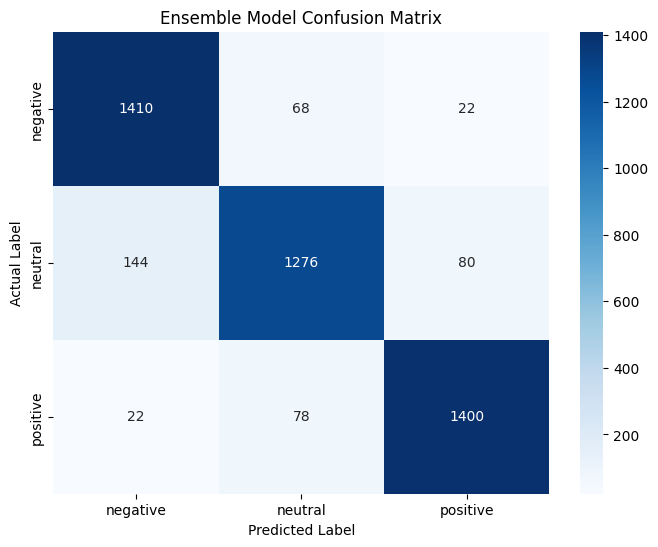

In [13]:
# Generate the confusion matrix from the results
cm = confusion_matrix(results['y_true'], results['y_pred'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CANONICAL_LABELS, yticklabels=CANONICAL_LABELS)
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()